In [ ]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle
!chmod 600 ~/.kaggle

In [ ]:

import json

api_token = {
    "username":"",
    "key":""
}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [ ]:
!cp /root/.kaggle/kaggle.json ~/.kaggle/kaggle.json

cp: '/root/.kaggle/kaggle.json' and '/root/.kaggle/kaggle.json' are the same file


In [ ]:
!kaggle datasets download -d imadeddinedjerarda/mrl-eye-dataset

 99% 328M/330M [00:02<00:00, 109MB/s]
100% 330M/330M [00:02<00:00, 123MB/s]


In [ ]:
 !unzip /content/mrl-eye-dataset.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: mrleyedataset/Open-Eyes/s0036_05431_1_1_1_0_0_01.png  
  inflating: mrleyedataset/Open-Eyes/s0036_05432_1_1_1_0_0_01.png  
  inflating: mrleyedataset/Open-Eyes/s0036_05433_1_1_1_0_0_01.png  
  inflating: mrleyedataset/Open-Eyes/s0036_05434_1_1_1_0_0_01.png  
  inflating: mrleyedataset/Open-Eyes/s0036_05435_1_1_1_0_0_01.png  
  inflating: mrleyedataset/Open-Eyes/s0036_05436_1_1_1_0_0_01.png  
  inflating: mrleyedataset/Open-Eyes/s0036_05437_1_1_1_0_0_01.png  
  inflating: mrleyedataset/Open-Eyes/s0036_05438_1_1_1_0_0_01.png  
  inflating: mrleyedataset/Open-Eyes/s0036_05439_1_1_1_0_0_01.png  
  inflating: mrleyedataset/Open-Eyes/s0036_05440_1_1_1_0_0_01.png  
  inflating: mrleyedataset/Open-Eyes/s0036_05441_1_1_1_0_0_01.png  
  inflating: mrleyedataset/Open-Eyes/s0036_05442_1_1_1_0_0_01.png  
  inflating: mrleyedataset/Open-Eyes/s0036_05443_1_1_1_0_0_01.png  
  inflating: mrleyedataset/Open-Eyes/s0036_05444_1_1_1_0_

In [ ]:
import os
import shutil

source_path = '/content/mrleyedataset'
destination_path = '/content/dataset-mata'

source_path_close = os.path.join(source_path, 'Close-Eyes')
source_path_open = os.path.join(source_path, 'Open-Eyes')

# Create destination directories
destination_path_close = os.path.join(destination_path, 'Close-Eyes')
destination_path_open = os.path.join(destination_path, 'Open-Eyes')

os.makedirs(destination_path_close, exist_ok=True)
os.makedirs(destination_path_open, exist_ok=True)

# Function to copy specified number of images from source to destination
def copy_images(source_path, destination_path, num_images):
    images = os.listdir(source_path)[:num_images]
    for image in images:
        source_file = os.path.join(source_path, image)
        destination_file = os.path.join(destination_path, image)
        shutil.copyfile(source_file, destination_file)

# Copy 5,000 images from each class to the new directories
copy_images(source_path_close, destination_path_close, 2000)
copy_images(source_path_open, destination_path_open, 2000)

# Verify the number of images in the new directories
print(f"There are {len(os.listdir(destination_path_close))} images of Close-eyes in the new directory.")
print(f"There are {len(os.listdir(destination_path_open))} images of Open-eyes in the new directory.")


There are 2000 images of Close-eyes in the new directory.
There are 2000 images of Open-eyes in the new directory.


In [ ]:
root_dir = '/content/mreyedatasets'


if os.path.exists(root_dir):
  shutil.rmtree(root_dir)


def create_train_val_dirs(root_path):
  """
  Creates directories for the train and test sets

  Args:
    root_path (string) - the base directory path to create subdirectories from

  Returns:
    None
  """


  os.makedirs(os.path.join(root_path, 'training'))
  os.makedirs(os.path.join(f'{root_path}/training', 'close'))
  os.makedirs(os.path.join(f'{root_path}/training', 'open'))
  os.makedirs(os.path.join(root_path, 'validation'))
  os.makedirs(os.path.join(f'{root_path}/validation', 'close'))
  os.makedirs(os.path.join(f'{root_path}/validation', 'open'))




try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [ ]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/content/mreyedatasets/validation
/content/mreyedatasets/training
/content/mreyedatasets/validation/close
/content/mreyedatasets/validation/open
/content/mreyedatasets/training/close
/content/mreyedatasets/training/open


In [ ]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  shuffled_source = random.sample(os.listdir(SOURCE_DIR), len(os.listdir(SOURCE_DIR)))
  training_number = int(len(shuffled_source) * SPLIT_SIZE)
  i = 0
  target = TRAINING_DIR

  for item in shuffled_source:
    item_source = os.path.join(SOURCE_DIR, item)
    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else:
      copyfile(item_source, os.path.join(target, item))
      i += 1

    if i == training_number:
      target = VALIDATION_DIR


In [ ]:
CLOSE_SOURCE_DIR = "/content/dataset-mata/Close-Eyes"
OPEN_SOURCE_DIR = "/content/dataset-mata/Open-Eyes"

TRAINING_DIR = "/content/mreyedatasets/training"
VALIDATION_DIR = "/content/mreyedatasets/validation"

TRAINING_CLOSE_DIR = os.path.join(TRAINING_DIR, "close/")
VALIDATION_CLOSE_DIR = os.path.join(VALIDATION_DIR, "close/")

TRAINING_OPEN_DIR = os.path.join(TRAINING_DIR, "open/")
VALIDATION_OPEN_DIR = os.path.join(VALIDATION_DIR, "open/")

if len(os.listdir(TRAINING_CLOSE_DIR)) > 0:
  for file in os.scandir(TRAINING_CLOSE_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_OPEN_DIR)) > 0:
  for file in os.scandir(TRAINING_OPEN_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CLOSE_DIR)) > 0:
  for file in os.scandir(VALIDATION_CLOSE_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_OPEN_DIR)) > 0:
  for file in os.scandir(VALIDATION_OPEN_DIR):
    os.remove(file.path)


split_size = .9

split_data(CLOSE_SOURCE_DIR, TRAINING_CLOSE_DIR , VALIDATION_CLOSE_DIR , split_size)
split_data(OPEN_SOURCE_DIR, TRAINING_OPEN_DIR, VALIDATION_OPEN_DIR, split_size)

print(f"\n\nOriginal CLOSE directory has {len(os.listdir(CLOSE_SOURCE_DIR))} images")
print(f"Original OPEN directory has {len(os.listdir(OPEN_SOURCE_DIR))} images\n")

print(f"There are {len(os.listdir(TRAINING_CLOSE_DIR))} images of CLOSEfor training")
print(f"There are {len(os.listdir(TRAINING_OPEN_DIR))} images of OPEN for training")
print(f"There are {len(os.listdir(VALIDATION_CLOSE_DIR))} images of CLOSE for validation")
print(f"There are {len(os.listdir(VALIDATION_OPEN_DIR))} images of OPEN for validation")



Original CLOSE directory has 2000 images
Original OPEN directory has 2000 images

There are 1800 images of CLOSEfor training
There are 1800 images of OPEN for training
There are 200 images of CLOSE for validation
There are 200 images of OPEN for validation


In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale = 1./255.,
                                     rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode = 'nearest')

  train_generator = train_datagen.flow_from_directory(directory = TRAINING_DIR,
                                                      batch_size = 32,
                                                      class_mode = 'binary',
                                                      target_size = (150, 150))

  validation_datagen =ImageDataGenerator(rescale = 1./255.)


  validation_generator = validation_datagen.flow_from_directory(directory = VALIDATION_DIR,
                                                                batch_size = 32,
                                                                class_mode = 'binary',
                                                                target_size = (150, 150))

  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 3600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop

# Load pre-trained MobileNetV2 model from TensorFlow Hub
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze layers in base model
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callback untuk menyimpan model berdasarkan validation loss terbaik
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Train your model as usual
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[checkpoint]
)


Epoch 1/10
112/112 [==============================] - ETA: 0s - loss: 0.4337 - accuracy: 0.8119
Epoch 1: val_loss improved from inf to 0.30847, saving model to best_model.h5
112/112 [==============================] - 27s 219ms/step - loss: 0.4337 - accuracy: 0.8119 - val_loss: 0.3085 - val_accuracy: 0.8776
Epoch 2/10
112/112 [==============================] - ETA: 0s - loss: 0.3065 - accuracy: 0.8803
Epoch 2: val_loss improved from 0.30847 to 0.26100, saving model to best_model.h5
112/112 [==============================] - 24s 213ms/step - loss: 0.3065 - accuracy: 0.8803 - val_loss: 0.2610 - val_accuracy: 0.8958
Epoch 3/10
112/112 [==============================] - ETA: 0s - loss: 0.2681 - accuracy: 0.9005
Epoch 3: val_loss improved from 0.26100 to 0.24781, saving model to best_model.h5
112/112 [==============================] - 24s 214ms/step - loss: 0.2681 - accuracy: 0.9005 - val_loss: 0.2478 - val_accuracy: 0.9036
Epoch 4/10
112/112 [==============================] - ETA: 0s - loss

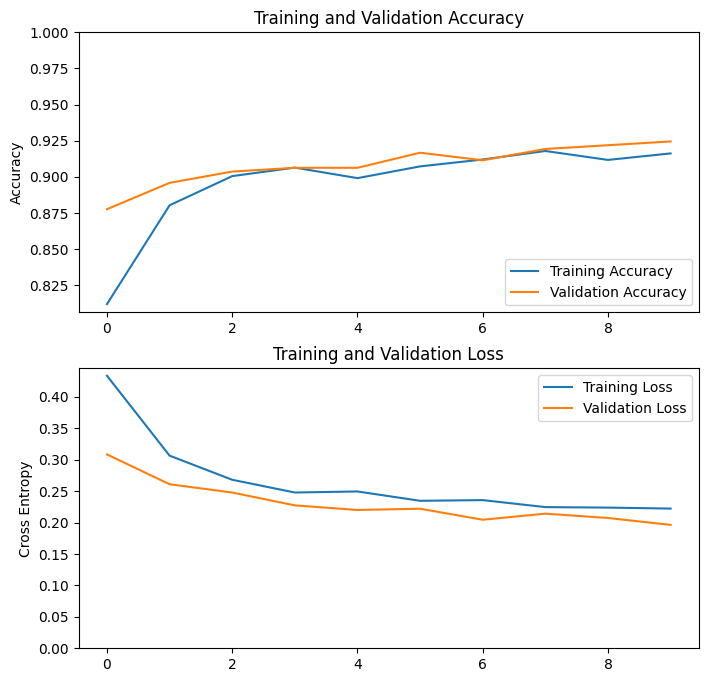

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(validation_generator)
print('test accuracy : ', test_acc)

13/13 [==============================] - 0s 31ms/step - loss: 0.2047 - accuracy: 0.9175
test accuracy :  0.9175000190734863


In [ ]:
model.save("Model 6.h5")

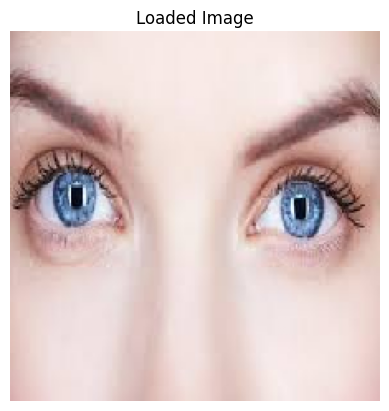

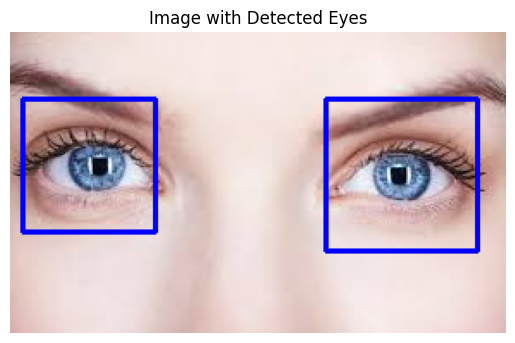

1/1 [==============================] - 1s 769ms/step


Probability for Open Eyes Class: 0.8745213
Classified: Open Eyes 




In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow import keras

def detect_eyes_haar_cascade(img_path):
    # Load the image using OpenCV
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Load the pre-trained Haar Cascade for eyes
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    # Detect eyes in the image
    eyes = eye_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Draw rectangles around the eyes
    for (x, y, w, h) in eyes:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Display the image with detected eyes
    plt.title("Image with Detected Eyes")
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def predict_eyes(img_rel_path, model_path="Model.h5", threshold=0.5):
    # Check if the model file exists
    if not os.path.exists(model_path):
        print(f"Error: Model file '{model_path}' not found.")
        return

    # Load the model
    loaded_model = keras.models.load_model(model_path)

    # Import Image from the path with size of (224, 224) for example (adjust based on your model input size)
    img = image.load_img(img_rel_path, target_size=(224, 224))

    # Convert Image to a numpy array
    img = image.img_to_array(img)

    # Scaling the Image Array values between 0 and 1
    img = img / 255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Detect eyes using Haar Cascade
    detect_eyes_haar_cascade(img_rel_path)

    # Get the Predicted Label for the loaded Image
    predictions = loaded_model.predict(img[np.newaxis, ...])

    # Probability for the "Open Eyes" class (index 1)
    open_eyes_probability = predictions[0][0]

    print("\n\nProbability for Open Eyes Class:", open_eyes_probability)

    # Classify based on the threshold
    if open_eyes_probability >= threshold:
        predicted_class = 'Open Eyes'
    else:
        predicted_class = 'Closed Eyes'

    print("Classified:", predicted_class, "\n\n")

# Example usage:
img_path = "/content/download (5).jpeg"  # Ganti dengan path gambar yang ingin Anda prediksi
predict_eyes(img_path)

